In [ ]:
import torch
import torch.nn as nn
import torch.nn.utils.parametrize as parametrize
from torch.distributions.multivariate_normal import MultivariateNormal as MN
from torch.utils.data import DataLoader
import numpy as np
import math
import sys
import os
import time
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


# settings for running on a specified Google Drive account.
from google.colab import drive
drive.mount('/content/gdrive')
gdrive_path = "/content/gdrive/MyDrive/"

# Paths and import custom scripts.
root = '.../SEGP/'
GP_path = gdrive_path + root + 'Code/SEGP/'
dataset_number = 1
data_path = gdrive_path + root + 'Data/Datasets/VAE/Dataset{0}'.format(dataset_number)

if GP_path in sys.path:
  print('directory already in path!')
else:
  sys.path.append(GP_path)

import SEGP


# Setup directory to store models.
model_path = gdrive_path + root + 'Data/Models/'
model_name = 'SEGP_VAE'
exp_no = 3
model_dir = model_path + model_name + '/Exp_{:03d}/'.format(exp_no)

if os.path.isdir(model_dir):
    raise Exception("File already exists! Not overwriting.")
else:
    os.makedirs(model_dir)

# Hardware settings.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print('Default tensor type is now cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
print("Device in use is: ", device)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
directory already in path!
Device in use is:  cpu


## Utility functions

In [ ]:
def plot_latents(loc:str, file:str, vid_batch:torch.tensor, dY:torch.tensor, nplots:int,
                 recon_batch=None, recon_traj=None, recon_covar=None):
    """
    Plots videos, latent states and reconstructions.
    args:
             loc: location to store file.
            file: filename.
       vid_batch: (_, N, d, d) tensor of videos.
              dY: (_, N, m) tensor of latent states.
          nplots: number of cols of plot, col row is one video.
     recon_batch: (_, N, d, d) tensor of reconstructed videos.
      recon_traj: (_, N, m) tensor of reconstructed trajectory.
     recon_covar: (_, m*N, m*N) covariance matrix of lent state.
    returns:
              ax: figure object with all plots.
    """

    if recon_batch is not None:
        fig, ax = plt.subplots(3, nplots, figsize=(6, 8))
    else:
        fig, ax = plt.subplots(2, nplots, figsize=(6, 4))

    fig.tight_layout()

    for axi in ax:
        for axj in axi:
            axj.clear()

    _, N, _, _ = vid_batch.shape

    # get axis limits for the latent space
    xmin = np.min( [dY[:nplots,:,0].min().cpu() -0.1, -2.5] )
    xmax = np.max( [dY[:nplots,:,0].max().cpu() +0.1, +2.5] )
    ymin = np.min( [dY[:nplots,:,1].min().cpu() -0.1, -2.5] )
    ymax = np.max( [dY[:nplots,:,1].max().cpu() +0.1, +2.5] )

    def make_heatmap(vid):
        """
        args:
               vid: N, d, d
        returns:
          flat_vid: d, d
        """
        vid = torch.stack( [(t+4)*v for t,v in enumerate(vid)], dim=0 )
        flat_vid = (1/(4+tmax)) * torch.max(vid, 0).values
        return flat_vid


    def plot_set(i):
        # i: batch element / plot column

        # first row is original video
        vid = make_heatmap(vid_batch[i,:,:,:])
        ax[0][i].imshow(1-vid.cpu(), origin='lower', cmap='Greys')
        ax[0][i].axis('off')

        # second row is trajectories
        ax[1][i].plot(dY[i,:,0].cpu(), dY[i,:,1].cpu())
        ax[1][i].set_xlim([xmin, xmax])
        ax[1][i].set_ylim([ymin, ymax])
        ax[1][i].scatter(dY[i,0,0].cpu(), dY[i,0,1].cpu(), marker='o', c='C0')
        ax[1][i].scatter(dY[i,-1,0].cpu(), dY[i,-1,1].cpu(), marker='*', c='C0')

        if recon_traj is not None:
            ax[1][i].plot(recon_traj[i,:,0].cpu(), recon_traj[i,:,1].cpu(), c='C1')
            ax[1][i].scatter(recon_traj[i,0,0].cpu(), recon_traj[i,0,1].cpu(), marker='o', c='C1')
            ax[1][i].scatter(recon_traj[i,-1,0].cpu(), recon_traj[i,-1,1].cpu(), marker='*', c='C1')

        # Third row is reconstructed video
        if recon_batch is not None:
            recon = make_heatmap(recon_batch[i,:,:,:])
            ax[2][i].imshow(1-recon.cpu(), origin='lower', cmap='Greys')
            ax[2][i].axis('off')

    for i in range(nplots):
        plot_set(i)

    fig.savefig(loc + file + '.png')
    plt.show()


    if recon_traj is not None:
        recon_var = torch.diag( recon_covar[0] ) # shape = (m*N)
        recon_conf = 2 * torch.sqrt( recon_var ).cpu() # shape = (m*N)

        fig, ax = plt.subplots(1, 2, figsize=(10, 3))
        ax[0].plot( dT.cpu(), dY[0,:,0].cpu(), 'r*' )
        ax[0].plot( dT.cpu(), recon_traj[0,:,0].cpu() )
        ax[0].fill_between(dT.cpu(), recon_traj[0,:,0].cpu() - recon_conf[:N],
                            recon_traj[0,:,0].cpu() + recon_conf[:N], alpha=0.5, label='95% CI')
        ax[1].plot( dT.cpu(), dY[0,:,1].cpu(), 'r*' )
        ax[1].plot( dT.cpu(), recon_traj[0,:,1].cpu() )
        ax[1].fill_between(dT.cpu(), recon_traj[0,:,1].cpu() - recon_conf[N:],
                            recon_traj[0,:,1].cpu() + recon_conf[N:], alpha=0.5, label='95% CI')

        fig.savefig(loc + file + '_posterior.png')
        plt.show()

    return 0



In [ ]:
def get_dataloaders(vid_batch:torch.tensor, dY:torch.tensor,
                      batches:int, bs:int, test_split:float, idx=None, test_idx=None):
  """
  Function for splitting data into train and test dataloaders. Latent states corresponding to
  test loader data are also returned for plotting purposes.
  args:
         vid_batch: data to split with shape = (M, Q, N, d, d).
                dY: latent states to split in same way for plots (M, Q, N, m).
           batches: number of batches.
                bs: batch size.
        test_split: ratio of batches to reserve for testing.
               idx: indices for repeating a particular shuffle of vid_batch, dY.
          test_idx: indices for repeating a particular train/test split.
  returns:
      train_loader: dataloader with shape = (batches - N_test, bs, N, d, d).
       test_loader: dataloader with shape = (N_test, bs, N, d, d).
           dY_test: latent states corresponding to test loader; shape = (N_test, bs, N, m).
               idx: indices for repeating a particular shuffle of vid_batch, dY.
          test_idx: indices for repeating a particular train/test split.
  """

  M, Q, N, d, _ = vid_batch.shape
  m = dY.shape[3]

  vid_batch = vid_batch.view(M*Q, N, d, d) # shape = (M * Q, N, d, d)
  dY = dY.view(M*Q, N, m) # shape = (M * Q, N, m)

  # reshape into shapes = (batches, bs, N, d, d), (batches, bs, N, m)
  if batches * bs != M * Q:
      print('M =', M)
      print('Q =', Q)
      raise Exception("batches * bs != M * Q!")
  else:
      vid_batch = vid_batch.view(batches, bs, N, d, d)
      dY = dY.view(batches, bs, N, m)

  if idx == None:
      idx = torch.randperm(vid_batch.shape[0])

  # shuffle
  vid_batch = vid_batch[idx]
  dY = dY[idx]

  # split into train and test sets.
  N_test = int(batches * test_split)
  if N_test < 1:
      raise Exception("No batches reserved for testing!")

  if test_idx == None:
      test_idx = np.random.randint(low=0, high=batches, size=N_test)

  train_idx = np.delete( np.arange(0, batches), test_idx)

  test_loader = DataLoader(vid_batch[test_idx], batch_size=1, shuffle=False)
  train_loader = DataLoader(vid_batch[train_idx], batch_size=1, shuffle=False)
  dY_test = dY[test_idx]

  return train_loader, test_loader, dY_test, idx, test_idx

# import data.
data_setup = np.load(data_path + '/data_setup.pkl', allow_pickle=True)
dT = torch.from_numpy( np.load(data_path + '/dT.npy') )
mean_U = torch.from_numpy( np.load(data_path + '/mean_U.npy') )
mean_dU = torch.from_numpy( np.load(data_path + '/mean_dU.npy') )
dY = torch.from_numpy( np.load(data_path + '/dY.npy') ).to(device)
vid_batch = torch.from_numpy( np.load(data_path + '/vid_batch.npy') ).to(device)
tmax = data_setup['tmax']

# # use when restarting a previous run.
# idx = torch.from_numpy( np.load(model_dir + 'idx.npy') )
# test_idx = np.load(model_dir + 'test_idx.npy')

# setup data loaders.
batches = 10
bs = 1000
test_split = 0.1
train_loader, test_loader, Y_test, \
    idx, test_idx = get_dataloaders(vid_batch, dY, batches, bs,
                                    test_split) # , idx=idx, test_idx=test_idx)

with open(model_dir + 'idx.npy', 'wb') as f:
      np.save(f, idx.cpu())

with open(model_dir + 'test_idx.npy', 'wb') as f:
      np.save(f, test_idx)

del vid_batch, idx, test_idx
if device.type == 'cuda':
  torch.cuda.empty_cache()


## SEGP-VAE Model.

Note that SEGP class is imported in, so just encoder and decoder classes defined here.

In [ ]:
class VAEEncoder(nn.Module):
    '''
    Encoder. Maps frames (bs, N, d, d) to mean (bs, N, m) and variance (bs, N, m) of likelihood.
    self.encoder returns log(var) to avoid numerical stability issues.
    args:
          input_dim: flattened dimension of image (d * d).
         hidden_dim: dimension of hidden layer.
         output_dim: dimension of latent state (m).
    '''

    def __init__(self, input_dim:int, hidden_dim:int, output_dim:int):
        super(VAEEncoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.encoder = nn.Sequential(
                                    nn.Linear(input_dim, hidden_dim),
                                    nn.Tanh(),
                                    nn.Linear(hidden_dim, 2*output_dim)
                                    )

        for i in self.encoder.modules():
            if isinstance(i, nn.Linear):
                nn.init.normal_(i.weight, mean=0, std=1e-2)
                nn.init.constant_(i.bias, val=0)


    def forward(self, x):
        x = torch.flatten(x, start_dim=2, end_dim=3) # shape = (bs, N, d*d)
        out = self.encoder(x) # shape = (bs, N, 2*m)

        # constant term sets min(var) to ensure covariance matrix is positive def.
        mean = out[:, :, :self.output_dim] # shape = (bs, N, m)
        var = torch.exp( out[:, :, self.output_dim:] ) + 1e-3 # shape = (bs, N, m)

        return mean, var



class VAEDecoder(nn.Module):
    '''
    Decoder. Maps latent states (bs, N, m) to logits of Bernoulli dist. (bs, N, d*d).
    Returns logits rather than probabilities due to format required for nn.BCEWithLogitsLoss().
    args:
          input_dim: dimension of latent state (m).
         hidden_dim: diemension of hidden layer.
         output_dim: flattened dimension of image (d * d).
    '''

    def __init__(self, input_dim:int, hidden_dim:int, output_dim:int):
        super(VAEDecoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.decoder = nn.Sequential(
                                    nn.Linear(input_dim, hidden_dim),
                                    nn.Tanh(),
                                    nn.Linear(hidden_dim, output_dim)
                                    )

        for i in self.decoder.modules():
            if isinstance(i, nn.Linear):
                nn.init.normal_(i.weight, mean=0, std=1e-2)
                # nn.init.constant_(i.weight, val=0) # init. so most pixels are black.
                nn.init.constant_(i.bias, val=0)

    def forward(self, x):
        return self.decoder(x) # -6.0 # translate so most pixels are init. black.



## Training VAE

In [ ]:
class ELBO(nn.Module):
    """
    Class for computing the three terms of the ELBO objective: reconstruction term,
    GCE and log marginal likelihood, each for a batch of data with shape (bs, N, m).
    args:
          weights: 3d tensor containing weights for each term of the ELBO objective
                   (recon, GCE, mll).
    """

    def __init__(self, weights:torch.tensor):
        super().__init__()
        self.weights = weights
        self.BCE = nn.BCEWithLogitsLoss(reduction='none')
        self.register_buffer('pi', torch.tensor(math.pi) )


    def Cholesky_inverse(self, covar):
        """
        Computes inverse of covar via Cholesky decomposition.
        args:
                covar: Covariance matrix with shape (bs, m*N, m*N).
        returns:
                covar_inv: Inverse of covar for each element in batch (bs, m*N, m*N).
        """
        L_inv = torch.inverse( torch.linalg.cholesky(covar) ) # shape = (bs, m*N, m*N)
        covar_inv = torch.bmm( L_inv.transpose(1,2), L_inv ) # shape = (bs, m*N, m*N)

        return covar_inv



    def recon(self, vid_batch:torch.tensor, p_theta_logits:torch.tensor):
        """
        Computes the average reconstruction term across a batch of data.
        args:
                 vid_batch: Observed images (bs, N, d, d).
            p_theta_logits: Logits of Bernouli distribution for each black/white pixel of image (bs, N, d, d, n_samples).
        returns:
                  recon_av: average reconstruction term (scalar).
        """

        bs, N, d, _, n_samples = p_theta_logits.shape

        recon = -self.BCE(p_theta_logits,
                         vid_batch.unsqueeze(4).repeat(1,1,1,1,n_samples)) # shape = (bs, N, d, d, n_samples)
        recon = recon.mean(dim=4) # shape = (bs, N, d, d)
        recon = recon.sum( dim=(3,2,1) ) # shape = (bs)

        recon_av = recon.mean()

        return recon_av


    def GCE(self, mean_lhood:torch.tensor, var_lhood:torch.tensor, mean_post:torch.tensor,
            covar_post:torch.tensor):
      """
          Computes the average Gaussian cross entropy term across a batch of data, when the lhood parametrises
          the integrand distribution and the posterior parametrisies the expectation
          args:
                mean_lhood: Mean of likelihood for latent states (bs, N, m).
                 var_lhood: Variance of likelihood for latent states (bs, N, m).
                 mean_post: SEGP posterior mean function (bs, N, m).
                covar_post: SEGP posterior covariance function (bs, m*N, m*N).
          returns:
                    GCE_av: Average Gaussian cross entropy term (scalar).
      """

      bs, N, m = mean_lhood.shape
      var_post = torch.diagonal(covar_post, dim1=-2, dim2=-1).unflatten( dim=1, sizes=(m, N) ).transpose(1,2) # shape = (bs, N, m)

      term1 = torch.log( 2 * self.pi * torch.ones(bs, N, m) ) # shape = (bs, N, m)
      term2 = 2 * torch.log( torch.sqrt(var_lhood) ) # shape = (bs, N, m)
      term3 = var_post + ( (mean_post - mean_lhood) * (mean_post - mean_lhood) ) # shape = (bs, N, m)
      term3 = term3 / var_lhood # shape = (bs, N, m)

      GCE = 0.5 * (term1 + term2 + term3).sum(dim=(1,2)) # shape = (bs)

      GCE_av = GCE.mean()

      return GCE_av



    def mll(self, mean_lhood:torch.tensor, mean_prior:torch.tensor, covar_prior:torch.tensor,
                covar_lhood:torch.tensor):
        """
        Computes the average marginal log likelihood across a batch of data.
        args:
               mean_lhood: Mean of likelihood for latent states (bs, N, m).
               mean_prior: SEGP mean function (N, m).
              covar_prior: SEGP covariance matrix (m*N, m*N).
              covar_lhood: Covariance of likelihood for latent states (bs, m*N, m*N).
        returns:
                      mll: average marginal log likelihood (scalar).
        """

        bs, N, m = mean_lhood.shape

        total_covar = covar_prior.repeat(bs,1,1) + covar_lhood # shape = (bs, m*N, m*N)

        self.register_buffer('eps', ( 1e-3 * torch.eye(m*N, m*N) ).repeat(bs,1,1) ) # shape = (bs, m*N, m*N)
        inv_tc = self.Cholesky_inverse(total_covar + self.eps) # shape = (bs, m*N, m*N)

        mean_lhood = torch.transpose(mean_lhood, 1, 2).reshape(bs, m*N).unsqueeze(2) # shape = (bs, m*N, 1)
        mean_prior = torch.transpose( mean_prior.repeat(bs, 1, 1), 1, 2).reshape(bs, m*N).unsqueeze(2) # shape = (bs, m*N, 1)

        term1 = torch.bmm( inv_tc, mean_lhood - mean_prior ) # shape = (bs, m*N, 1)
        term1 = -0.5 * torch.bmm( (mean_lhood - mean_prior).transpose(1, 2), term1 )  # shape = (bs, 1, 1)
        term1 = term1.squeeze(2).squeeze(1)


        # add eps to avoid numerical issues computing term2 when covar_noise < 0.1.
        if torch.min(covar_lhood) < 1e-1:
            self.register_buffer('eps', 1e-1 * torch.eye(m*N, m*N) )
            term2 = -0.5 * torch.log( torch.linalg.det(total_covar + self.eps) )
        else:
            term2 = -0.5 * torch.log( torch.linalg.det(total_covar) )

        term2 = term2.repeat(bs,1).squeeze(1) # shape = (bs)


        term3 = -0.5 * N * m * torch.log(2*self.pi)
        term3 = term3.repeat(bs,1).squeeze(1) # shape = (bs)


        mll = term1 + term2 + term3
        mll_av = mll.mean()

        return mll_av



    def forward(self, vid_batch:torch.tensor, p_theta_logits:torch.tensor, mean_lhood:torch.tensor,
                var_lhood:torch.tensor, mean_prior:torch.tensor, covar_prior:torch.tensor,
                mean_post:torch.tensor, covar_post:torch.tensor):
        """
        Computes ELBO objective.
        args:
                  vid_batch: Observed images (bs, N, d, d).
             p_theta_logits: Logits of Bernouli distribution for each black/white pixel of image (bs, N, d, d, n_samples).
                 mean_lhood: Mean of likelihood for latent states (bs, N, m).
                  var_lhood: Variance of likelihood for latent states (bs, N, m).
                 mean_prior: SEGP mean function (N, m).
                covar_prior: SEGP covariance matrix (m*N, m*N).
                  mean_post: SEGP posterior mean function (bs, N, m).
                 covar_post: SEGP posterior covariance matrix (bs, m*N, m*N).
        returns:
                   elbo_obj: ELBO objective (scalar).

        Note that for mll, var_lhood is converted to diagonal covariance matrix with
        shape = (bs, m*N, m*N).
        """

        self.recon_obj = self.weights[0] * self.recon(vid_batch, p_theta_logits) # should always be negative.
        self.GCE_obj = self.weights[1] * self.GCE(mean_lhood, var_lhood, mean_post, covar_post) # should always be positive.
        self.mll_obj = self.weights[2] * self.mll(mean_lhood, mean_prior, covar_prior,
                                var_lhood.transpose(1, 2).flatten(start_dim=1, end_dim=2).diag_embed())

        elbo_obj = self.recon_obj + self.GCE_obj + self.mll_obj

        return elbo_obj




In [ ]:
def lr_scheduler(epoch:int, optimizer, decay:float, decay_epochs:list):
    """
    Decay learning rate by a factor decay for every epoch in decay_epochs.
    args:
               epoch: Current epoch of training loop.
           optimizer: Optimizer with parameters from previous epoch.
               decay: Scalar to multiply lr by.
        decay_epochs: List containing the epochs which the lr should be cut at.
    returns:
           optimizer: Same optimizer as before with updated lr.
    """

    if epoch in decay_epochs:
      for param_group in optimizer.param_groups:
          param_group['lr'] = decay*param_group['lr']

      print( 'New learning rate is: %.4f' % ( param_group['lr']) )

    return optimizer


In [ ]:
def train(dT:torch.tensor, tmax, mean_U, mean_dU, train_loader, test_loader,
          max_epoch:int, enc, GP, dec, optimizer, elbo, decay:float, decay_epochs:list,
          model_dir:str, device, Y_test:torch.tensor, min_epoch=0,
          mean_train_elbo_losses=[], mean_train_recon_losses=[],mean_train_KL_losses=[],
          mean_test_elbo_losses=[], mean_test_recon_losses=[],mean_test_KL_losses=[] ):

    """
    Training loop.
    args:
                    dT: Sampled time points to compute the prior mean and covariance matrix.
                  tmax: Maximum time point.
                mean_U: "Continuous" mean function of U used in GP integrals.
               mean_dU: Discretised mean function of U corresponding to dT.
          train_loader: Dataloader for training set. Each batch has shape = (1, bs, N, m).
           test_loader: Dataloader for test set. Each batch has shape = (1, bs, N, m).
             max_epoch: Epoch which training will terminate at.
                   enc: Encoder.
                    GP: Gaussian Process.
                   dec: Decoder.
             optimizer: Chosen optimizer.
                  elbo: ELBO objective function.
                 decay: Scalar to multiply lr by.
          decay_epochs: List containing the epochs which the lr should be cut at.
             model_dir: Path to where models and data are stored.
                device: Hardware in use.
                Y_test: Ground truth latent states of test set (bs, N, m).
    optional:
              min_epoch: Epoch which training will start at.
 mean_train_elbo_losses: List containing elbo training loss at each epoch from disrupted run.
mean_train_recon_losses: List containing recon training loss at each epoch from disrupted run.
   mean_train_KL_losses: List containing KL training loss at each epoch from disrupted run.
  mean_test_elbo_losses: List containing elbo test loss at each epoch from disrupted run.
 mean_test_recon_losses: List containing recon test loss at each epoch from disrupted run.
    mean_test_KL_losses: List containing KL test loss at each epoch from disrupted run.

    returns:
           enc, GP, dec: Final version of the model.
    """

    if len(mean_train_elbo_losses) == 0:
        mean_train_elbo_losses = []
        mean_train_recon_losses = []
        mean_train_kl_losses = []

    if len(mean_test_elbo_losses) == 0:
        mean_test_elbo_losses = []
        mean_test_recon_losses = []
        mean_test_KL_losses = []

    for epoch in range(min_epoch, max_epoch):

        # training loop
        enc.train()
        GP.train()
        dec.train()

        batch_elbo_losses = []
        batch_recon_losses = []
        batch_KL_losses = []

        for batch, vid_batch in enumerate(train_loader):

            optimizer.zero_grad()
            vid_batch = vid_batch.squeeze(0).to(device).float() # shape = (bs, N, d, d)
            bs, N, d, _ = vid_batch.shape

            ##### model outputs #####
            mean_lhood, var_lhood = enc(vid_batch) # both (bs, N, m)
            mean_prior, covar_prior = GP(dT, tmax, mean_U, mean_dU) # (N, m) and (m*N, m*N) - same for all items in batch

            # var_lhood is converted to diagonal covariance matrix with shape = (bs, m*N, m*N)
            # and outputs have shape = (bs, N, m) & (bs, m*N, m*N)
            mean_post, covar_post = GP.posterior(dT, dT, tmax, tmax, mean_U, mean_U, mean_dU, mean_dU,
                                                 var_lhood.transpose(1, 2).flatten(start_dim=1, end_dim=2).diag_embed(), mean_lhood)

            samples = GP.sample_posterior() # (bs, N, m, n_samples=3)
            p_theta_logits = dec( samples.transpose(2,3) ).transpose(2,3).unflatten(dim=2, sizes=(d,d)) # (bs, N, d, d, n_samples)

            ##### compute loss #####
            loss_elbo = - elbo( vid_batch, p_theta_logits, mean_lhood, var_lhood,
                           mean_prior, covar_prior, mean_post, covar_post)

            loss_recon = - elbo.recon_obj.item()

            loss_KL = - (elbo.GCE_obj + elbo.mll_obj).item()


            ##### optimise #####
            loss_elbo.backward()
            optimizer.step()

            batch_elbo_losses.append( loss_elbo.item() )
            batch_recon_losses.append(loss_recon)
            batch_KL_losses.append(loss_KL)

        mean_train_elbo_losses.append( np.mean(batch_elbo_losses) )
        mean_train_recon_losses.append( np.mean(batch_recon_losses) )
        mean_train_KL_losses.append( np.mean(batch_KL_losses) )

        optimizer = lr_scheduler(epoch, optimizer, decay, decay_epochs)

        # testing loop
        enc.eval()
        GP.eval()
        dec.eval()

        batch_elbo_losses = []
        batch_recon_losses = []
        batch_KL_losses = []

        with torch.no_grad():
          for batch, vid_batch in enumerate(test_loader):

              vid_batch = vid_batch.squeeze(0).to(device).float() # shape = (bs, N, d, d)

              ##### model outputs #####
              mean_lhood, var_lhood = enc(vid_batch) # both (bs, N, m)
              mean_prior, covar_prior = GP(dT, tmax, mean_U, mean_dU) # (N, m) and (m*N, m*N) - same for all items in batch

              # var_lhood is converted to diagonal covariance matrix with shape = (bs, m*N, m*N)
              # and outputs have shape = (bs, N, m) & (bs, m*N, m*N)
              mean_post, covar_post = GP.posterior(dT, dT, tmax, tmax, mean_U, mean_U, mean_dU, mean_dU,
                                                   var_lhood.transpose(1, 2).flatten(start_dim=1, end_dim=2).diag_embed(), mean_lhood)

              samples = GP.sample_posterior() # (bs, N, m, n_samples=3)
              p_theta_logits = dec( samples.transpose(2,3) ).transpose(2,3).unflatten(dim=2, sizes=(d,d)) # (bs, N, d, d, n_samples)

              ##### compute loss #####
              loss_elbo = - elbo( vid_batch, p_theta_logits, mean_lhood, var_lhood,
                            mean_prior, covar_prior, mean_post, covar_post)

              loss_recon = - elbo.recon_obj.item()

              loss_KL = - ( elbo.GCE_obj + elbo.mll_obj ).item()

              batch_elbo_losses.append( loss_elbo.item() )
              batch_recon_losses.append(loss_recon)
              batch_KL_losses.append(loss_KL)

        mean_test_elbo_losses.append( np.mean(batch_elbo_losses) )
        mean_test_recon_losses.append( np.mean(batch_recon_losses) )
        mean_test_KL_losses.append( np.mean(batch_KL_losses) )

        print('Iter %d/%d - Train ELBO Loss: %.3f - Recon Loss: %.3f - KL Loss: %.3f'
          % (epoch + 1, max_epoch, mean_train_elbo_losses[epoch],
             mean_train_recon_losses[epoch], mean_train_KL_losses[epoch]) )

        print('Iter %d/%d - Test ELBO Loss: %.3f - Recon Loss: %.3f - KL Loss: %.3f'
          % (epoch + 1, max_epoch, mean_test_elbo_losses[epoch],
             mean_test_recon_losses[epoch], mean_test_KL_losses[epoch]) )


        if epoch % 1 == 0:
            # mean of Bernoulli for each pixel, averaged over n_samples.
            p_theta = torch.sigmoid(p_theta_logits).mean(dim=4) # shape = (bs, N, d, d)

            nplots = 3
            fig = plt.gcf()
            string = 'latents_{0}'.format(epoch+1)
            plot_latents(model_dir, string, vid_batch, Y_test, nplots,
                          recon_batch=p_theta, recon_traj=mean_post, recon_covar=covar_post)
            fig.tight_layout()
            plt.show()


        # save models
        enc_path = model_dir + 'Encoder/epoch{:03d}.pt'.format(epoch+1)
        GP_path = model_dir + 'GP/epoch{:03d}.pt'.format(epoch+1)
        dec_path = model_dir + 'Decoder/epoch{:03d}.pt'.format(epoch+1)

        try:
              torch.save(enc.state_dict(), enc_path)
              torch.save(GP.state_dict(), GP_path)
              torch.save(dec.state_dict(), dec_path)
        except:
              os.makedirs(model_dir + 'Encoder/')
              os.makedirs(model_dir + 'GP/')
              os.makedirs(model_dir + 'Decoder/')
              torch.save(enc.state_dict(), enc_path)
              torch.save(GP.state_dict(), GP_path)
              torch.save(dec.state_dict(), dec_path)

        # save stats.
        stats_path = model_dir + 'stats.csv'
        stats = pd.DataFrame()
        stats["train elbo loss"] = mean_train_elbo_losses
        stats["train recon loss"] = mean_train_recon_losses
        stats["train KL loss"] = mean_train_KL_losses
        stats["test elbo loss"] = mean_test_elbo_losses
        stats["test recon loss"] = mean_test_recon_losses
        stats["test KL loss"] = mean_test_KL_losses
        stats.to_csv(stats_path, index=False)

        if device.type == 'cuda':
          torch.cuda.empty_cache()

    return enc, GP, dec



parameter count = 1605604
--- 1736949798.2341874 seconds ---
Iter 51/100 - Train ELBO Loss: 6901.306 - Recon Loss: 5386.630 - KL Loss: 1514.676
Iter 51/100 - Test ELBO Loss: 5974.355 - Recon Loss: 5114.733 - KL Loss: 859.622


<Figure size 640x480 with 0 Axes>

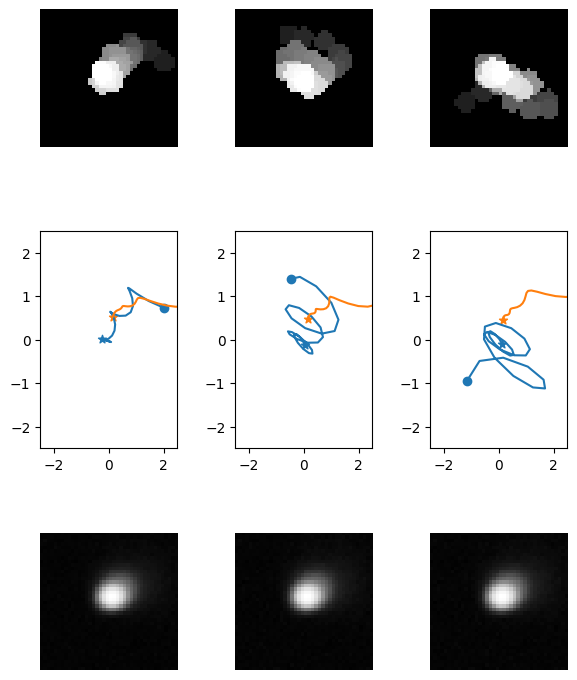

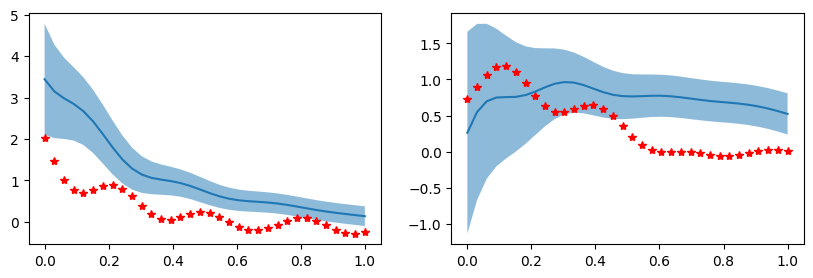

Iter 52/100 - Train ELBO Loss: 5455.620 - Recon Loss: 4521.753 - KL Loss: 933.867
Iter 52/100 - Test ELBO Loss: 4953.562 - Recon Loss: 4078.387 - KL Loss: 875.175


<Figure size 640x480 with 0 Axes>

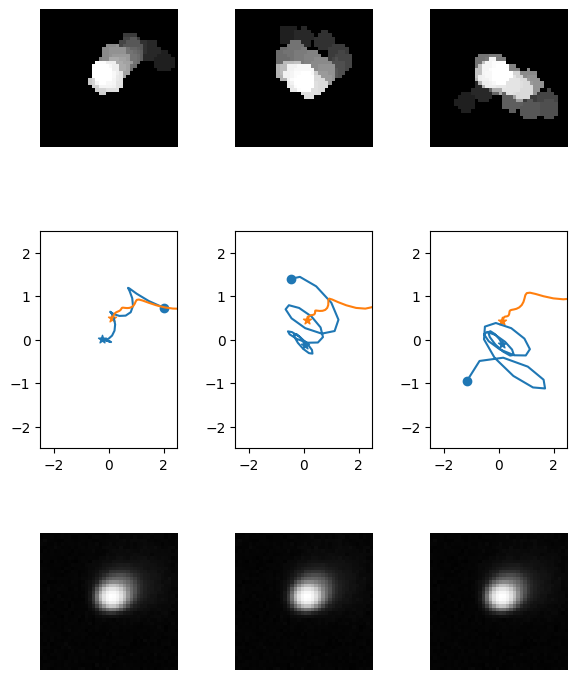

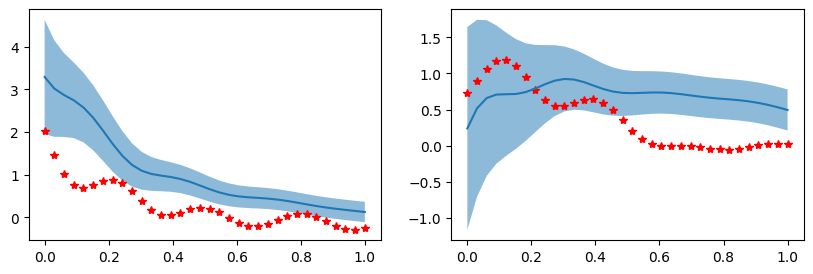

Iter 53/100 - Train ELBO Loss: 7652.841 - Recon Loss: 5912.782 - KL Loss: 1740.059
Iter 53/100 - Test ELBO Loss: 7496.988 - Recon Loss: 5715.315 - KL Loss: 1781.674


<Figure size 640x480 with 0 Axes>

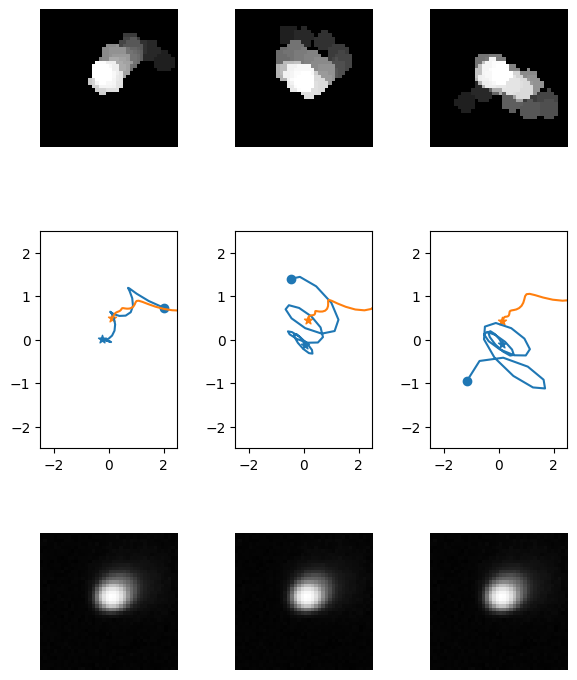

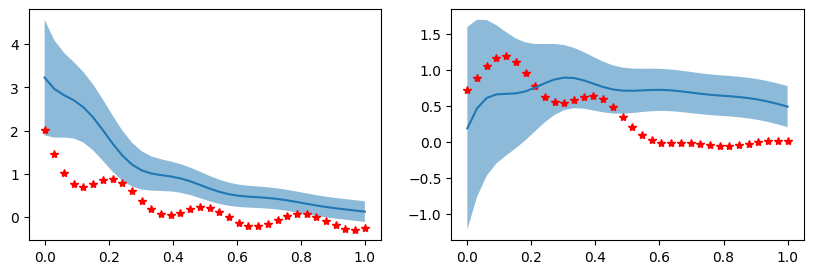

Iter 54/100 - Train ELBO Loss: 7412.580 - Recon Loss: 5755.935 - KL Loss: 1656.644
Iter 54/100 - Test ELBO Loss: 7271.061 - Recon Loss: 5673.662 - KL Loss: 1597.398


<Figure size 640x480 with 0 Axes>

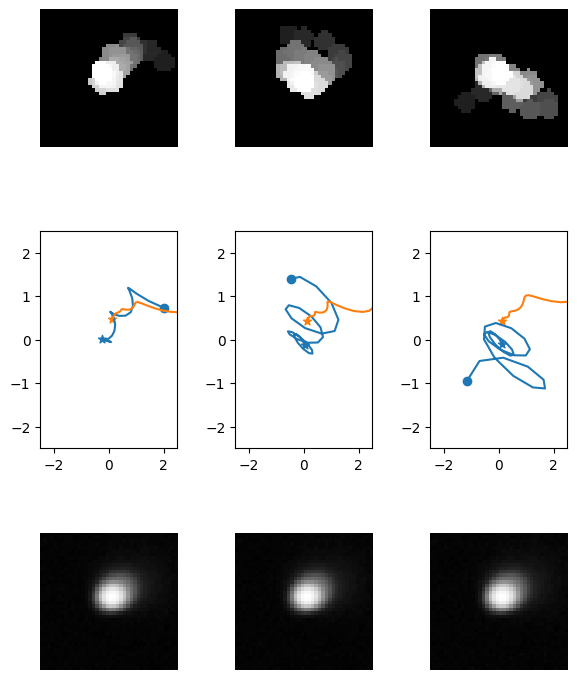

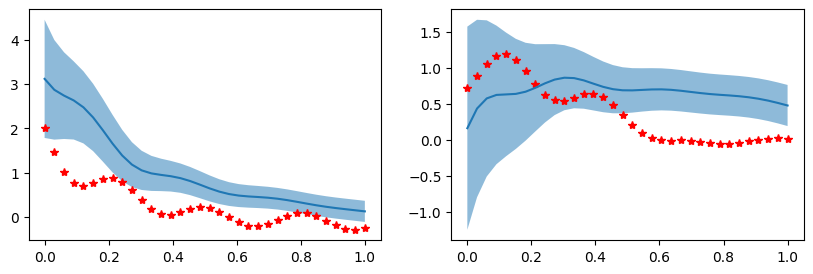

Iter 55/100 - Train ELBO Loss: 7193.453 - Recon Loss: 5621.315 - KL Loss: 1572.138
Iter 55/100 - Test ELBO Loss: 7056.135 - Recon Loss: 5474.919 - KL Loss: 1581.215


<Figure size 640x480 with 0 Axes>

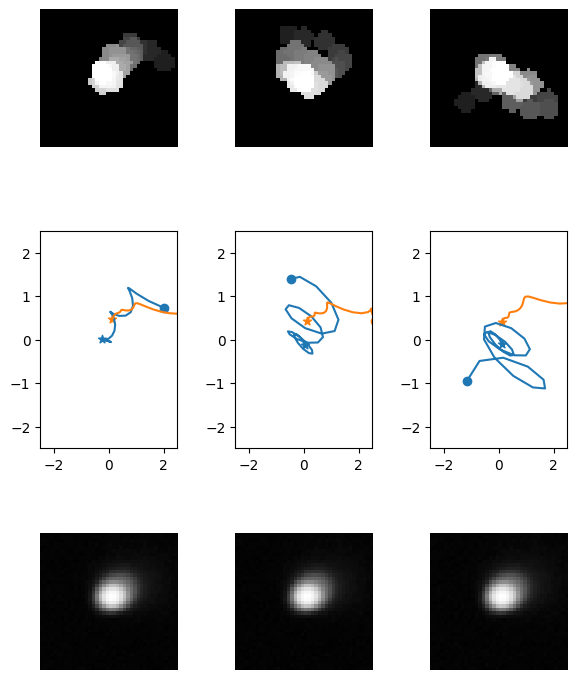

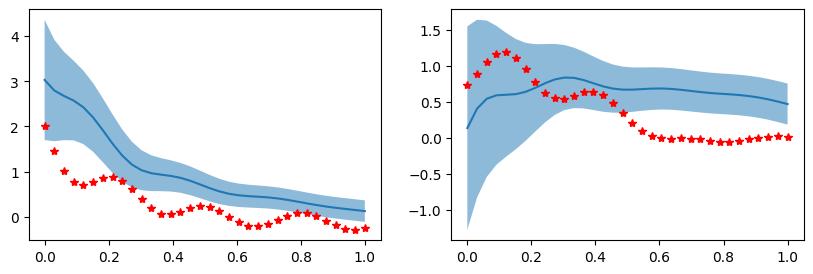

Iter 56/100 - Train ELBO Loss: 6989.987 - Recon Loss: 5462.567 - KL Loss: 1527.421
Iter 56/100 - Test ELBO Loss: 6858.029 - Recon Loss: 5370.615 - KL Loss: 1487.414


<Figure size 640x480 with 0 Axes>

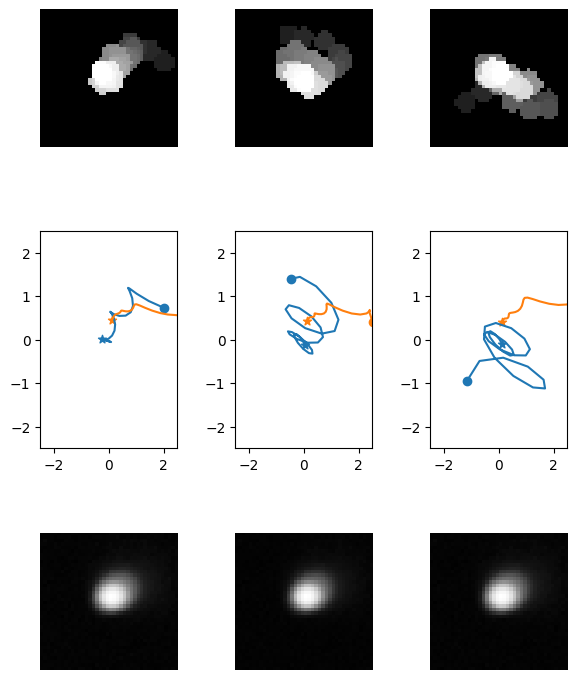

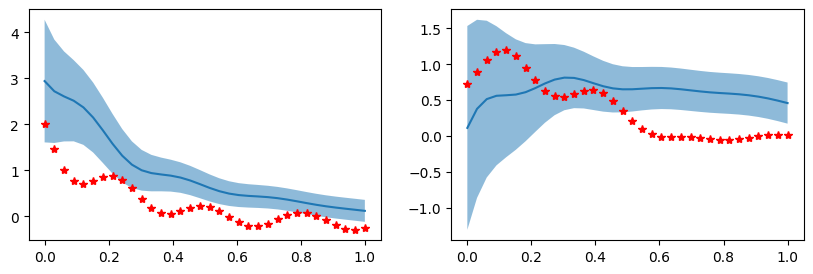

Iter 57/100 - Train ELBO Loss: 6803.230 - Recon Loss: 5358.299 - KL Loss: 1444.931
Iter 57/100 - Test ELBO Loss: 6672.562 - Recon Loss: 5246.034 - KL Loss: 1426.529


<Figure size 640x480 with 0 Axes>

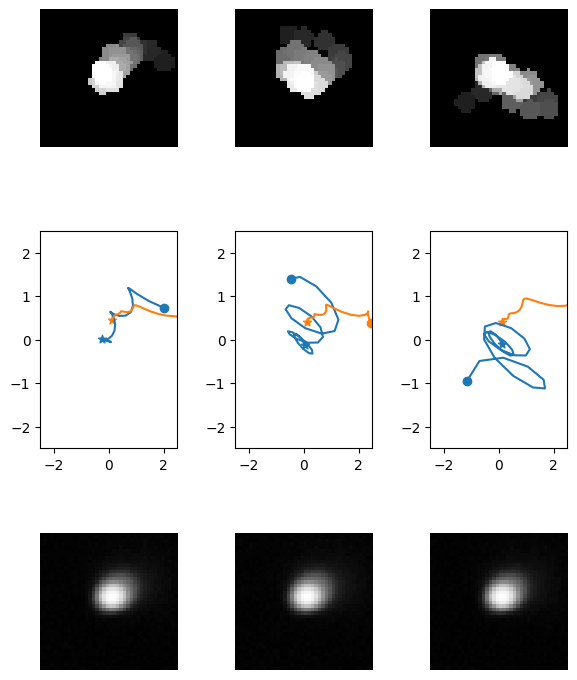

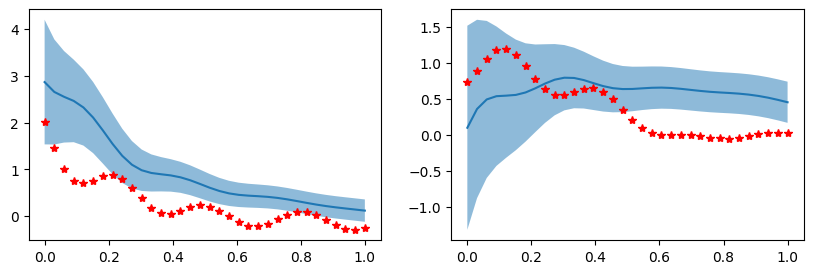

Iter 58/100 - Train ELBO Loss: 6621.046 - Recon Loss: 5230.854 - KL Loss: 1390.191
Iter 58/100 - Test ELBO Loss: 6526.671 - Recon Loss: 5168.146 - KL Loss: 1358.525


<Figure size 640x480 with 0 Axes>

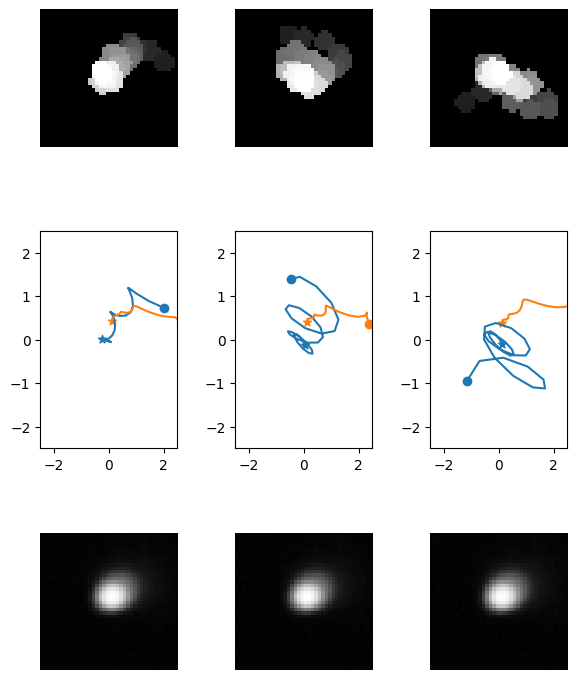

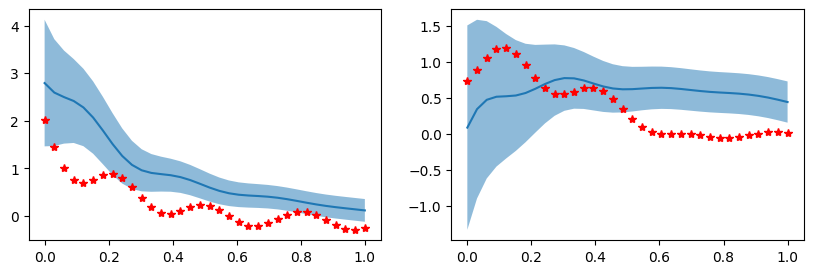

Iter 59/100 - Train ELBO Loss: 6466.028 - Recon Loss: 5138.051 - KL Loss: 1327.977
Iter 59/100 - Test ELBO Loss: 6370.085 - Recon Loss: 5066.276 - KL Loss: 1303.809


<Figure size 640x480 with 0 Axes>

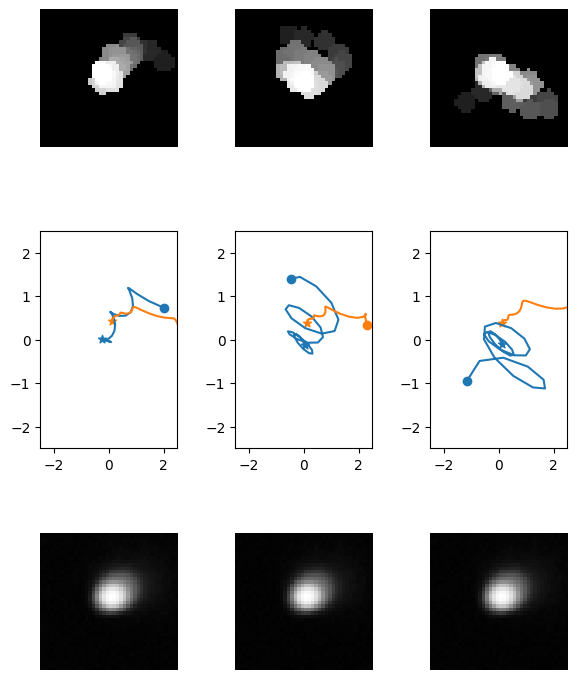

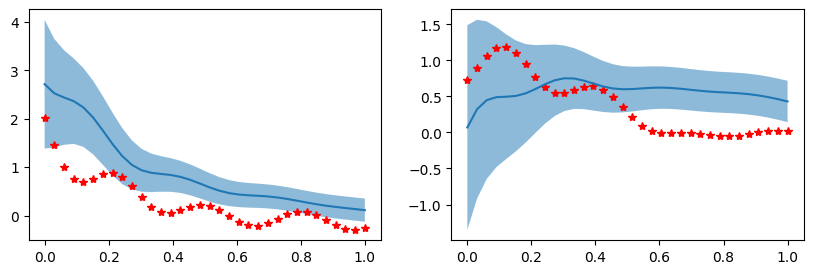

Iter 60/100 - Train ELBO Loss: 6312.247 - Recon Loss: 5035.565 - KL Loss: 1276.682
Iter 60/100 - Test ELBO Loss: 6217.830 - Recon Loss: 4971.139 - KL Loss: 1246.691


<Figure size 640x480 with 0 Axes>

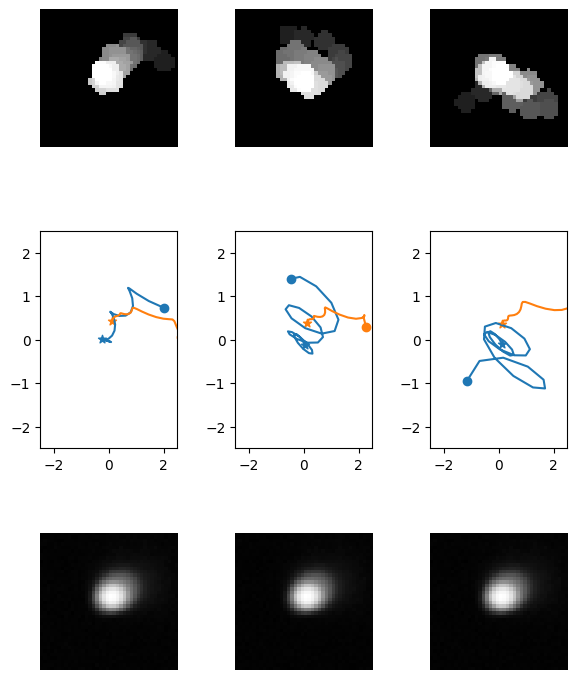

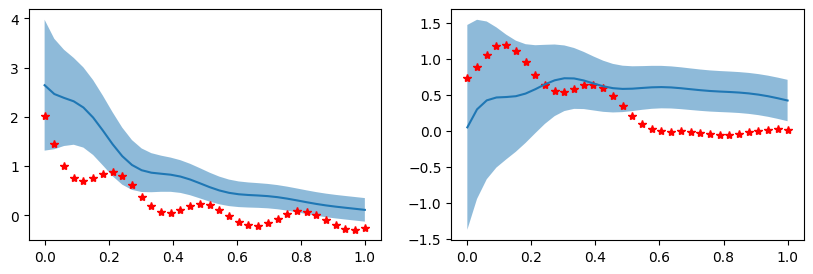

Iter 61/100 - Train ELBO Loss: 6168.913 - Recon Loss: 4947.580 - KL Loss: 1221.333
Iter 61/100 - Test ELBO Loss: 6092.688 - Recon Loss: 4901.953 - KL Loss: 1190.734


<Figure size 640x480 with 0 Axes>

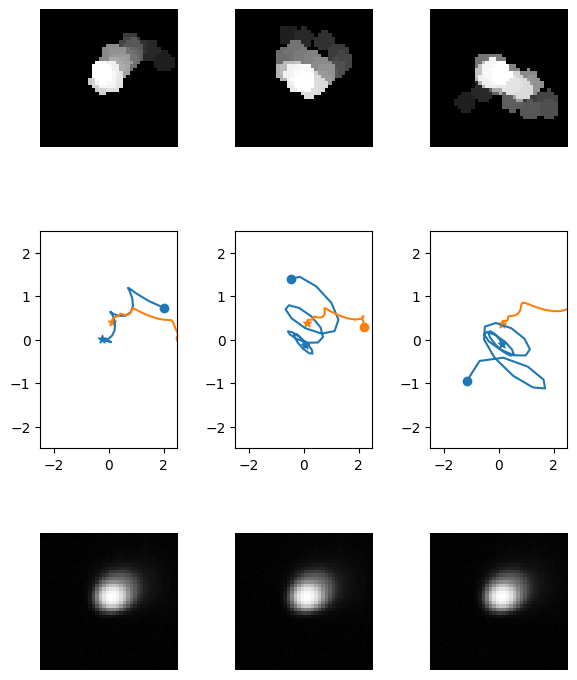

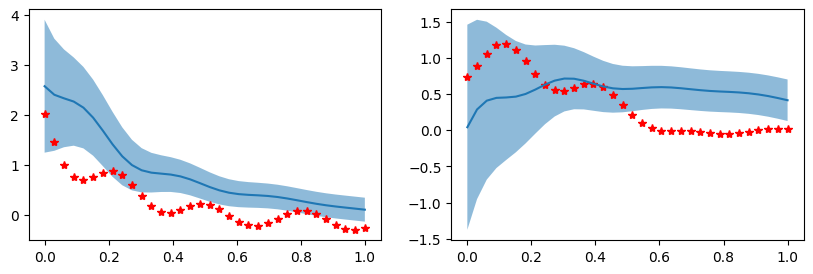

Iter 62/100 - Train ELBO Loss: 6042.566 - Recon Loss: 4868.641 - KL Loss: 1173.925
Iter 62/100 - Test ELBO Loss: 5965.888 - Recon Loss: 4818.491 - KL Loss: 1147.396


<Figure size 640x480 with 0 Axes>

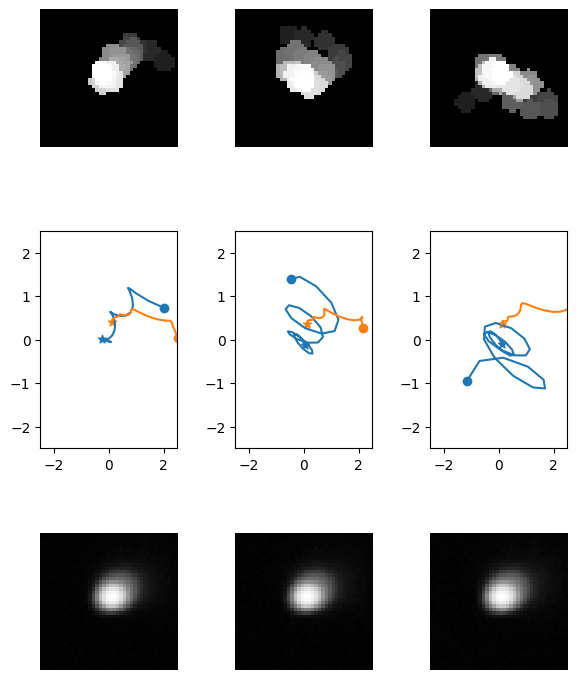

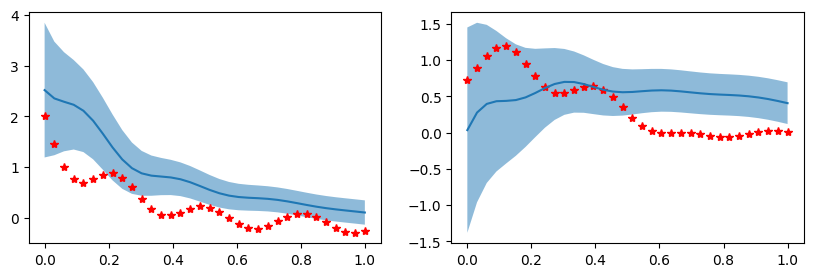

Iter 63/100 - Train ELBO Loss: 5923.020 - Recon Loss: 4792.791 - KL Loss: 1130.230
Iter 63/100 - Test ELBO Loss: 5861.119 - Recon Loss: 4760.296 - KL Loss: 1100.822


<Figure size 640x480 with 0 Axes>

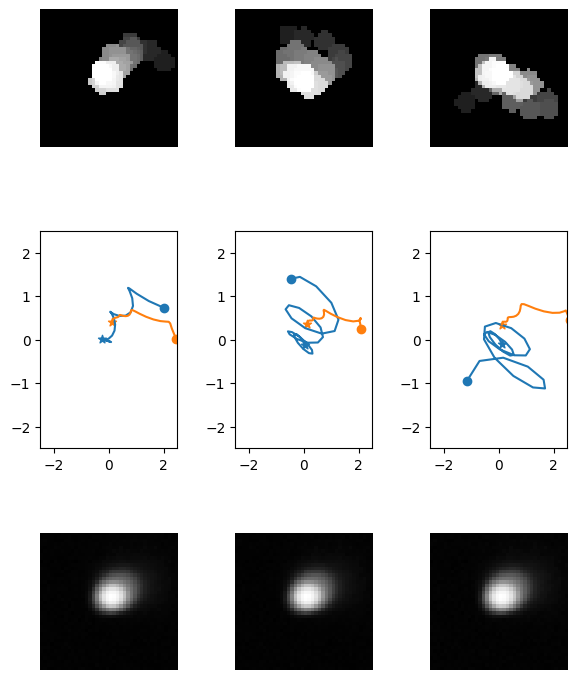

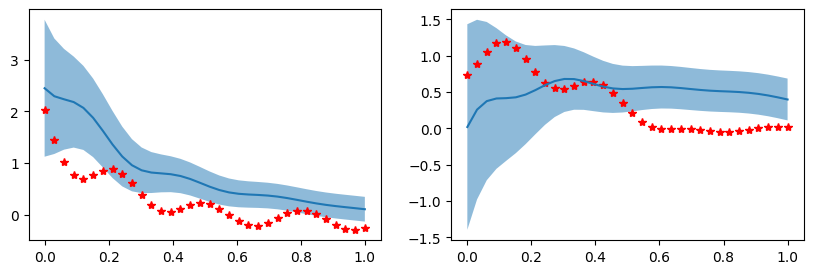

Iter 64/100 - Train ELBO Loss: 5812.393 - Recon Loss: 4723.439 - KL Loss: 1088.954
Iter 64/100 - Test ELBO Loss: 5745.316 - Recon Loss: 4684.236 - KL Loss: 1061.080


<Figure size 640x480 with 0 Axes>

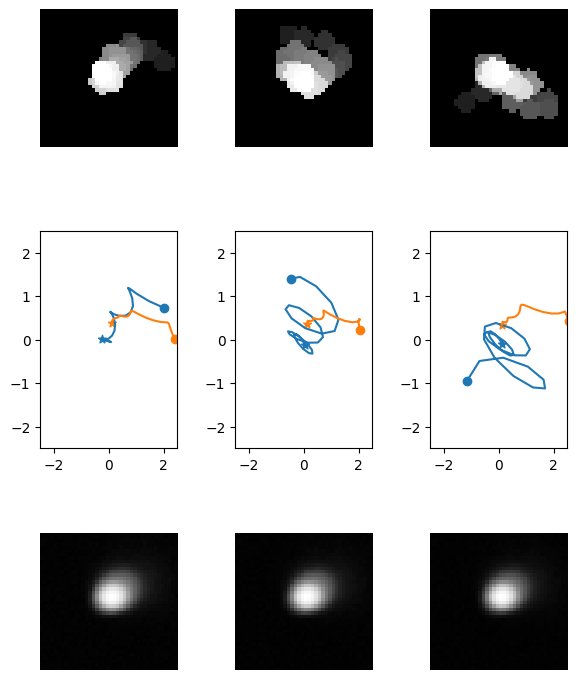

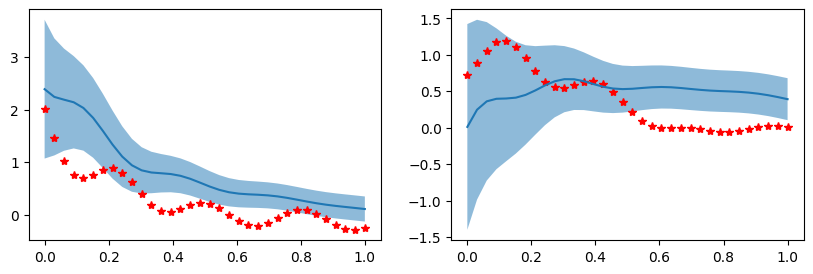

Iter 65/100 - Train ELBO Loss: 5705.610 - Recon Loss: 4656.588 - KL Loss: 1049.022
Iter 65/100 - Test ELBO Loss: 5659.889 - Recon Loss: 4642.619 - KL Loss: 1017.270


<Figure size 640x480 with 0 Axes>

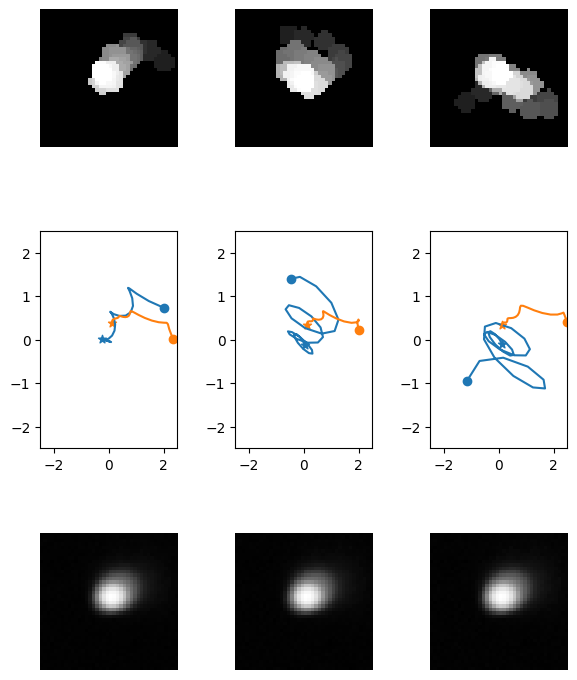

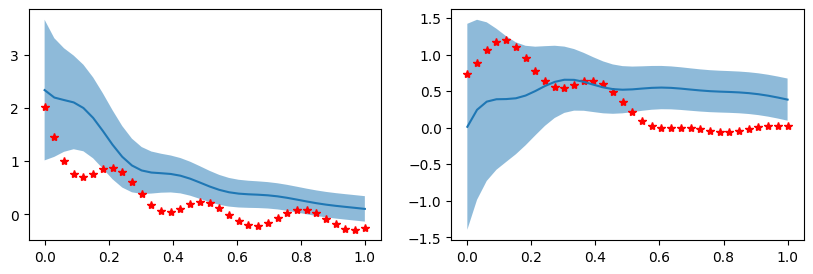

Iter 66/100 - Train ELBO Loss: 5610.894 - Recon Loss: 4601.420 - KL Loss: 1009.474
Iter 66/100 - Test ELBO Loss: 5557.420 - Recon Loss: 4574.049 - KL Loss: 983.371


<Figure size 640x480 with 0 Axes>

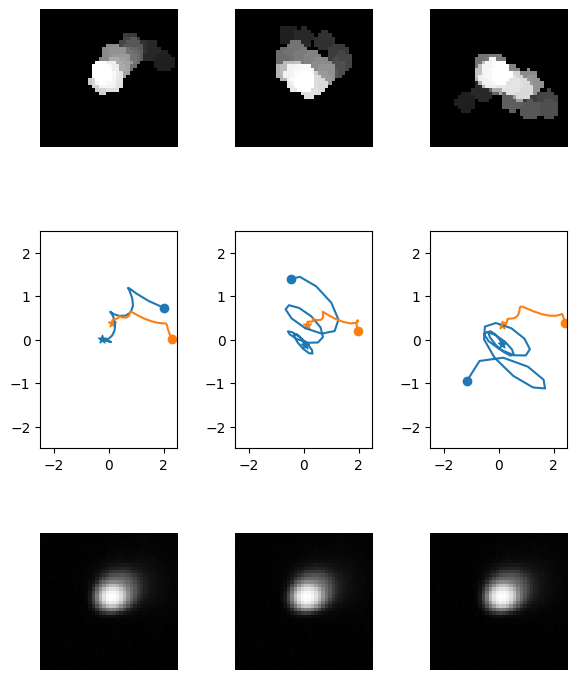

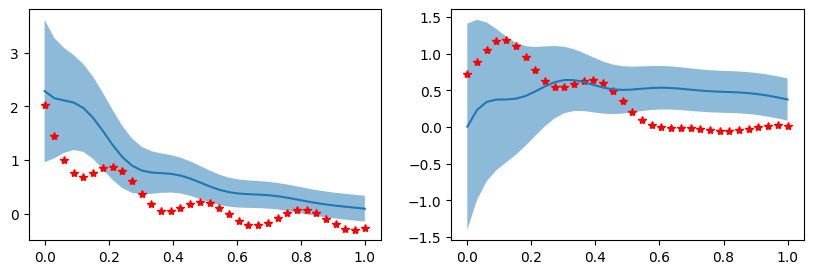

Iter 67/100 - Train ELBO Loss: 5510.174 - Recon Loss: 4533.381 - KL Loss: 976.793
Iter 67/100 - Test ELBO Loss: 5470.167 - Recon Loss: 4525.274 - KL Loss: 944.893


<Figure size 640x480 with 0 Axes>

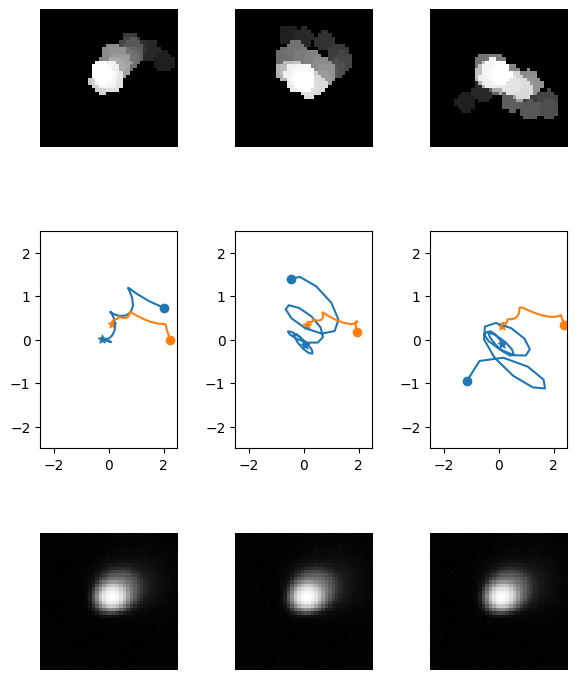

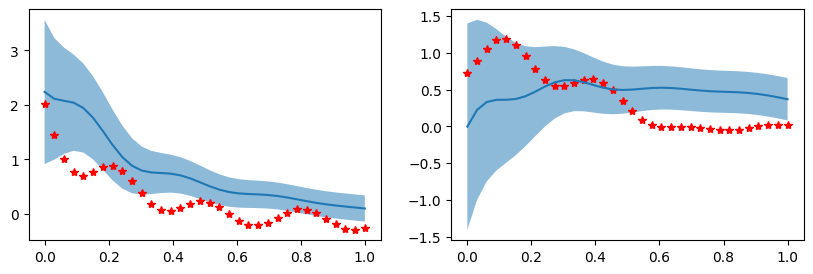

Iter 68/100 - Train ELBO Loss: 5430.962 - Recon Loss: 4493.806 - KL Loss: 937.156
Iter 68/100 - Test ELBO Loss: inf - Recon Loss: 4481.880 - KL Loss: inf


<Figure size 640x480 with 0 Axes>

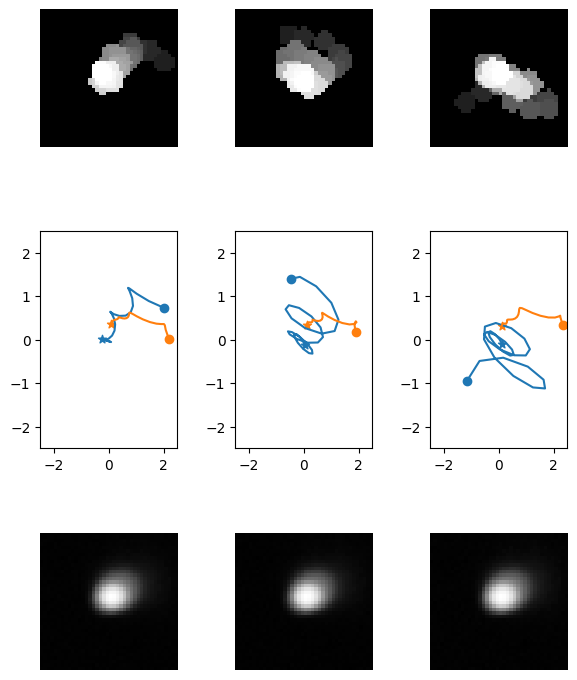

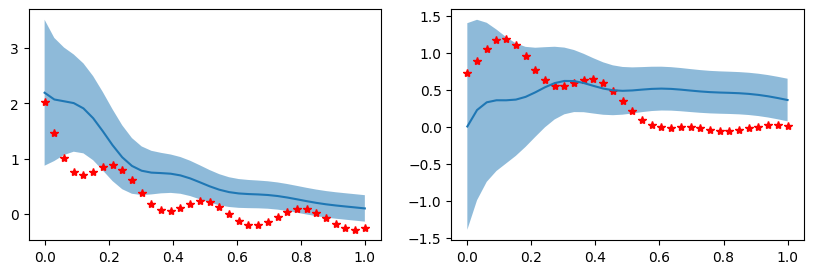

Iter 69/100 - Train ELBO Loss: 5349.626 - Recon Loss: 4439.614 - KL Loss: 910.012
Iter 69/100 - Test ELBO Loss: inf - Recon Loss: 4428.513 - KL Loss: inf


<Figure size 640x480 with 0 Axes>

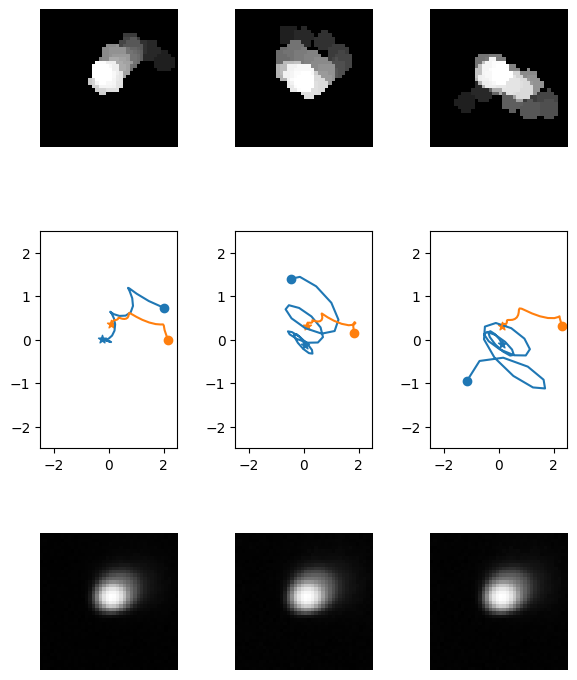

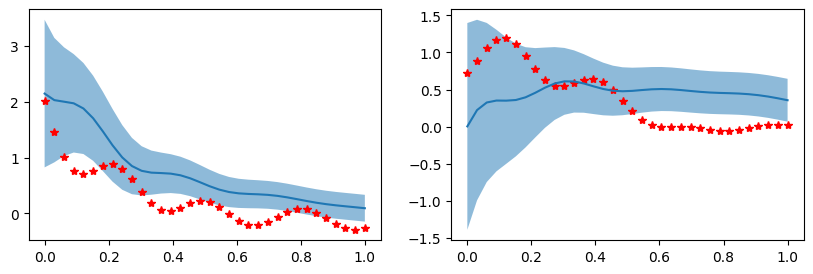

Iter 70/100 - Train ELBO Loss: 5275.557 - Recon Loss: 4395.795 - KL Loss: 879.762
Iter 70/100 - Test ELBO Loss: inf - Recon Loss: 4376.849 - KL Loss: inf


<Figure size 640x480 with 0 Axes>

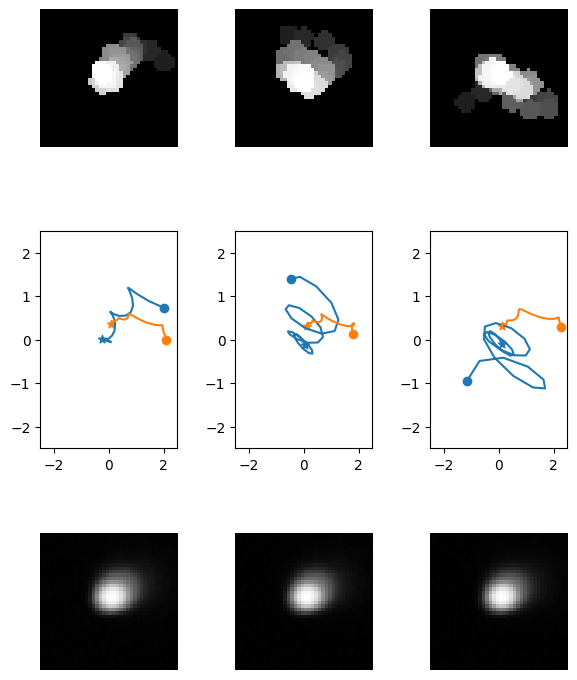

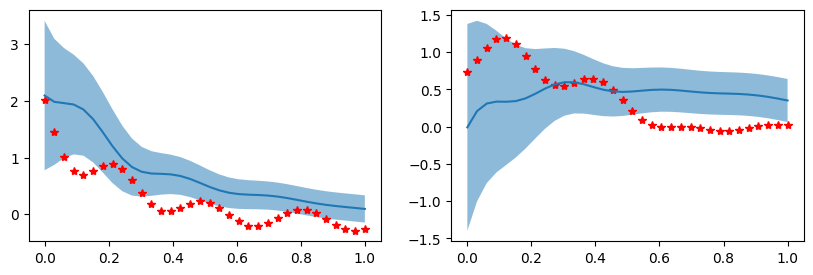

Iter 71/100 - Train ELBO Loss: 5199.793 - Recon Loss: 4351.458 - KL Loss: 848.335
Iter 71/100 - Test ELBO Loss: inf - Recon Loss: 4357.366 - KL Loss: inf


<Figure size 640x480 with 0 Axes>

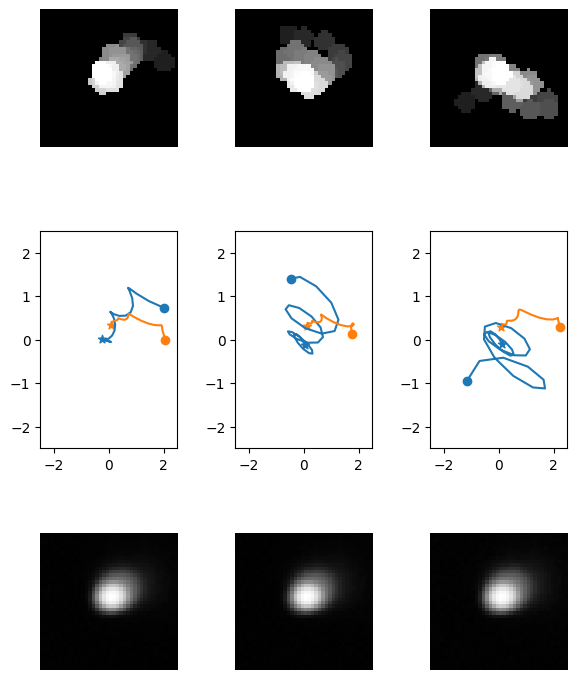

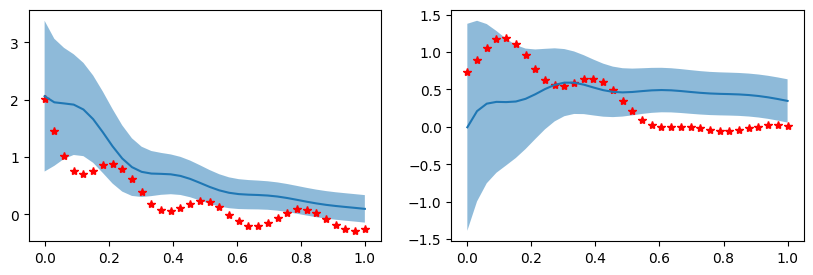

_LinAlgError: linalg.cholesky: (Batch element 0): The factorization could not be completed because the input is not positive-definite (the leading minor of order 1 is not positive-definite).

In [ ]:
# Training loop.

# # comment out when happy to overwrite.
# if os.path.isdir(model_dir):
#     raise Exception("File already exists! Not overwriting.")

# Training settings.
min_epoch = 50
max_epoch = 100


# Instantiate loss - weighted ELBO.
weights = torch.tensor([1.0, 100.0, 100.0]) # weight of (recon, GCE, mll) terms.
elbo = ELBO(weights)


# Instantiate model.
A_train = data_setup['A'] # None
B_train = data_setup['B'] # None
C_train = data_setup['C'] # None
D_train = data_setup['D'] # None
h_dim = 500
m = data_setup['m']
n = data_setup['n']
p = data_setup['p']
lt = data_setup['lt']
mean_x0 = data_setup['mean_x0']
covar_x0 = data_setup['covar_x0']
d = data_setup['d']

GP = SEGP.SEGP(m, n, p, lt, mean_x0, covar_x0, A_train, B_train, C_train, D_train).to(device)
enc = VAEEncoder(d*d, h_dim, m).to(device)
dec = VAEDecoder(m, h_dim, d*d).to(device)

model_settings = {'m':m, 'n':n, 'p':p, 'lt':lt, 'mean_x0':mean_x0, 'covar_x0':covar_x0,
                  'A_train':A_train, 'B_train':B_train, 'C_train':C_train, 'D_train':D_train,
                    'd':d, 'h_dim':h_dim}


# Instantiate optimiser.
lr = 1e-4
wd = 1e-5 # weight decay
decay = 1e-1 # scalar to multiply lr by at decay_epochs
decay_epochs = [] # epochs to perform lr cut
optimizer = torch.optim.Adam(list(enc.parameters()) + list(GP.parameters()) + list(dec.parameters()),
                             lr=lr, weight_decay=wd)


train_settings = {'lr':lr, 'wd':wd, 'decay':decay, 'decay_epochs':decay_epochs,
                    'max_epoch':max_epoch}


with open(model_dir + 'model_settings.pkl', 'wb') as f:
    pickle.dump(model_settings, f)
    f.close()
with open(model_dir + 'train_settings.pkl', 'wb') as f:
    pickle.dump(train_settings, f)
    f.close()


enc_params = sum(p.numel() for p in enc.parameters() if p.requires_grad)
GP_params = sum(p.numel() for p in GP.parameters() if p.requires_grad)
dec_params = sum(p.numel() for p in dec.parameters() if p.requires_grad)
print( 'parameter count =',  enc_params + GP_params + dec_params)

start_time = time.time()
print( "--- %s seconds ---" % (start_time) )

dT = dT.to(device)
mean_U = mean_U.to(device)
mean_dU = mean_dU.to(device)


# Train model.
if min_epoch == 0: # start new run
    enc, GP, dec = train(dT, tmax,  mean_U, mean_dU, train_loader, test_loader, max_epoch,
                              enc, GP, dec, optimizer, elbo, decay, decay_epochs, model_dir,
                                device, Y_test[0])
else: # continue interuppted run

    # load model, optimizer, losses
    enc.load_state_dict( torch.load( model_dir + 'Encoder/epoch{:03d}.pt'.format(min_epoch), weights_only=True ) )
    GP.load_state_dict( torch.load( model_dir + 'GP/epoch{:03d}.pt'.format(min_epoch), weights_only=True ) )
    dec.load_state_dict( torch.load( model_dir + 'Decoder/epoch{:03d}.pt'.format(min_epoch), weights_only=True ) )
    optimizer = lr_scheduler(min_epoch, optimizer, decay, decay_epochs)
    mean_train_elbo_losses = pd.read_csv(model_dir + 'stats.csv')['train elbo loss'].to_numpy().tolist()
    mean_train_recon_losses = pd.read_csv(model_dir + 'stats.csv')['train recon loss'].to_numpy().tolist()
    mean_train_KL_losses = pd.read_csv(model_dir + 'stats.csv')['train KL loss'].to_numpy().tolist()
    mean_test_elbo_losses = pd.read_csv(model_dir + 'stats.csv')['test elbo loss'].to_numpy().tolist()
    mean_test_recon_losses = pd.read_csv(model_dir + 'stats.csv')['test recon loss'].to_numpy().tolist()
    mean_test_KL_losses = pd.read_csv(model_dir + 'stats.csv')['test KL loss'].to_numpy().tolist()

    enc, GP, dec = train(dT, tmax,  mean_U, mean_dU, train_loader, test_loader, max_epoch,
                             enc, GP, dec, optimizer, elbo, decay, decay_epochs, model_dir,
                             device, Y_test[0], min_epoch=min_epoch,
                             mean_train_elbo_losses=mean_train_elbo_losses,
                             mean_train_recon_losses=mean_train_recon_losses,
                             mean_train_KL_losses=mean_train_KL_losses,
                             mean_test_elbo_losses=mean_test_elbo_losses,
                             mean_test_recon_losses=mean_test_recon_losses,
                             mean_test_KL_losses=mean_test_KL_losses
                         )


exe_time = time.time() - start_time
print( "--- %s seconds ---" % (exe_time) )


train_settings = {'lr':lr, 'wd':wd, 'decay':decay, 'decay_epochs':decay_epochs,
                  'max_epoch':max_epoch, 'exe_time':exe_time}

with open(model_dir + 'train_settings.pkl', 'wb') as f:
    pickle.dump(train_settings, f)
    f.close()


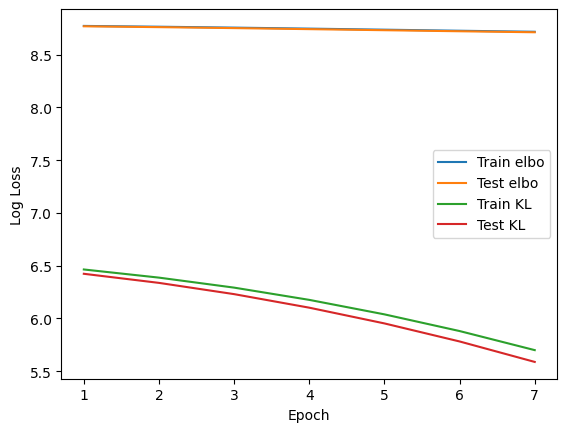

In [ ]:
# Plot loss

mean_train_elbo_losses = pd.read_csv(model_dir + 'stats.csv')['train elbo loss'].to_numpy().tolist()
mean_test_elbo_losses = pd.read_csv(model_dir + 'stats.csv')['test elbo loss'].to_numpy().tolist()
mean_train_recon_losses = pd.read_csv(model_dir + 'stats.csv')['train recon loss'].to_numpy().tolist()
mean_test_recon_losses = pd.read_csv(model_dir + 'stats.csv')['test recon loss'].to_numpy().tolist()
mean_train_KL_losses = pd.read_csv(model_dir + 'stats.csv')['train KL loss'].to_numpy().tolist()
mean_test_KL_losses = pd.read_csv(model_dir + 'stats.csv')['test KL loss'].to_numpy().tolist()

max_epoch = len(mean_train_elbo_losses)

# fig, ax = plt.subplots(1, 3, figsize=(10, 3))
# ax[0].plot(torch.arange(1,max_epoch+1).cpu(), np.log(mean_train_elbo_losses), label='Train elbo')
# ax[0].plot(torch.arange(1,max_epoch+1).cpu(), np.log(mean_test_elbo_losses), label='Test elbo')
# ax[1].plot(torch.arange(1,max_epoch+1).cpu(), np.log(mean_train_recon_losses), label='Train recon')
# ax[1].plot(torch.arange(1,max_epoch+1).cpu(), np.log(mean_test_recon_losses), label='Test recon')
# ax[2].plot(torch.arange(1,max_epoch+1).cpu(), np.log(mean_train_KL_losses), label='Train KL')
# ax[2].plot(torch.arange(1,max_epoch+1).cpu(), np.log(mean_test_KL_losses), label='Test KL')

# ax[0].set_xlabel('Epoch')
# ax[1].set_xlabel('Epoch')
# ax[2].set_xlabel('Epoch')
# ax[0].set_ylabel('Log Loss')

# ax.legend()
# ax.savefig(model_dir + "Loss.png")
# ax.show()